In [30]:
import pandas as pd
import numpy as np
from kneed import KneeLocator
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from helpers import *

In [31]:
random_state = 42
plotColor = ['b','g','r','m','c', 'y']
markers = ['+','o','*','^','v','>','<']

In [32]:
# import raw customer data
df_raw = pd.read_csv('E:/HDD Documents/HDD Documents/School/WGU/churn/churn_clean.csv')
df_raw.shape

(10000, 50)

In [33]:
# remove unwanted data
df_cleaned = df_raw.drop(columns=[
    'CaseOrder','UID', 'County', 
    'Interaction', 'City', 
    'Job', 'Zip','Population',
    'Lat', 'Lng','Item1','Item2',
    'Item3','Item4','Item5','Item6',
    'Item7','Item8'
])
df_cleaned.shape

(10000, 32)

In [34]:
# filter for lost customers
df_churn = df_cleaned.loc[(df_cleaned.Churn=="Yes")]
df_churn.shape


(2650, 32)

In [35]:
# filter numerical float variables
df_numerical = df_churn.select_dtypes(include="float")
df_numerical.info()
df_numerical.shape


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2650 entries, 1 to 9979
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Income              2650 non-null   float64
 1   Outage_sec_perweek  2650 non-null   float64
 2   Tenure              2650 non-null   float64
 3   MonthlyCharge       2650 non-null   float64
 4   Bandwidth_GB_Year   2650 non-null   float64
dtypes: float64(5)
memory usage: 124.2 KB


(2650, 5)

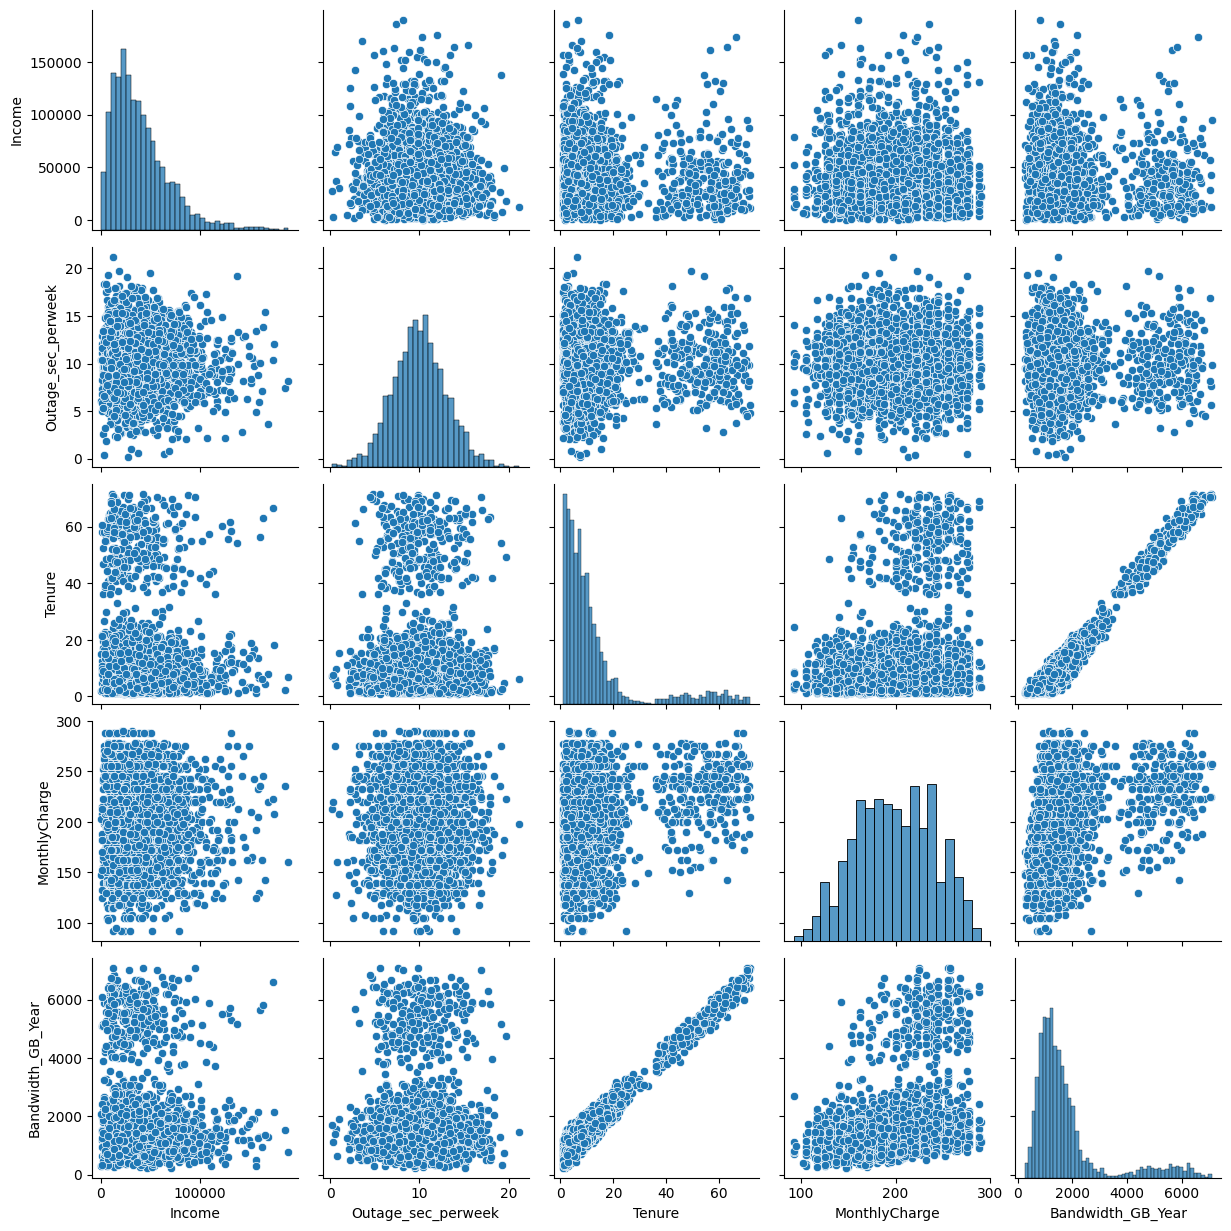

In [36]:
# describe combinations of numerical data
sns.pairplot(df_numerical)

In [37]:
# rename columns to facilitate output
df_numerical.rename(columns = {
    'Income':'INC', 
    'Outage_sec_perweek':'OUT',
    'Tenure':'TEN',
    'MonthlyCharge':'MCH',
    'Bandwidth_GB_Year':'BAN'
}, inplace = True)
df_numerical.info()
df_numerical.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2650 entries, 1 to 9979
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   INC     2650 non-null   float64
 1   OUT     2650 non-null   float64
 2   TEN     2650 non-null   float64
 3   MCH     2650 non-null   float64
 4   BAN     2650 non-null   float64
dtypes: float64(5)
memory usage: 124.2 KB


(2650, 5)

In [38]:
# describe numerical data - highlight small std
df = df_numerical.describe().round(3).T
def highlight_cells(val, color_if_true):
    color = color_if_true if val <= 3  else ''
    return 'background-color: {}'.format(color)
df[['mean','std','min','max']].style.applymap(highlight_cells, 
    color_if_true='yellow', subset=['std'])


,mean,std,min,max
INC,40085.758000,28623.988000,348.670000,189938.400000
OUT,10.001000,2.970000,0.232000,21.207000
TEN,13.148000,15.577000,1.000000,71.646000
MCH,199.295000,41.268000,92.455000,290.160000
BAN,1785.009000,1375.370000,248.179000,7096.495000


In [39]:
# remove highly correlated variables
df_final = df_numerical.drop(columns=['BAN'])
df_final.info()
df_final.shape


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2650 entries, 1 to 9979
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   INC     2650 non-null   float64
 1   OUT     2650 non-null   float64
 2   TEN     2650 non-null   float64
 3   MCH     2650 non-null   float64
dtypes: float64(4)
memory usage: 103.5 KB


(2650, 4)

In [40]:
# describe standardized data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_final.values)
df_standardized = pd.DataFrame(scaled_features,
        index=df_final.index, 
      columns=df_final.columns)
df = df_standardized.describe().round(2).T
def highlight_cells(val, color_if_true):
    color = color_if_true if val >= 3  else ''
    return 'background-color: {}'.format(color)
df[['mean','std','min','max']].style.applymap(highlight_cells, 
    color_if_true='yellow', subset=['max'])


,mean,std,min,max
INC,-0.000000,1.000000,-1.390000,5.240000
OUT,0.000000,1.000000,-3.290000,3.770000
TEN,-0.000000,1.000000,-0.780000,3.760000
MCH,-0.000000,1.000000,-2.590000,2.200000


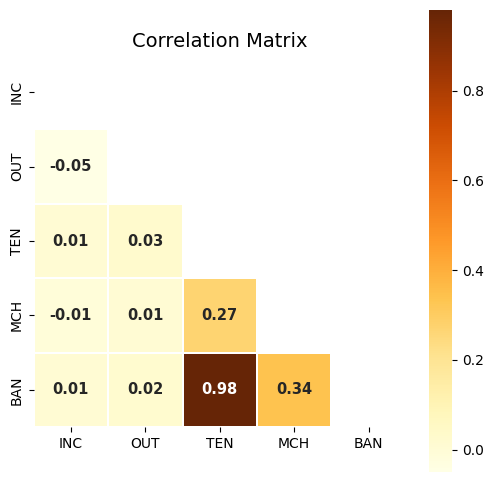

In [41]:
# use heatmap graph to identify highly correlated variables
def Generate_heatmap_graph(corr, chart_title, mask_uppertri=False ):
    """ Based on features , generate correlation matrix """
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = mask_uppertri
    fig,ax = plt.subplots(figsize=(6,6))
    sns.heatmap(corr
                , mask = mask
                , square = True
                , annot = True
                , annot_kws={'size': 10.5, 'weight' : 'bold'}
                , cmap=plt.get_cmap("YlOrBr")
                , linewidths=.1)
    plt.title(chart_title, fontsize=14)
    plt.show()

M = df_numerical
Generate_heatmap_graph(
    round(M.corr(),2), 
    chart_title = 'Correlation Matrix',
    mask_uppertri = True)    

Text(0.5, 1.0, "Lost Customers (Churn='Yes')")

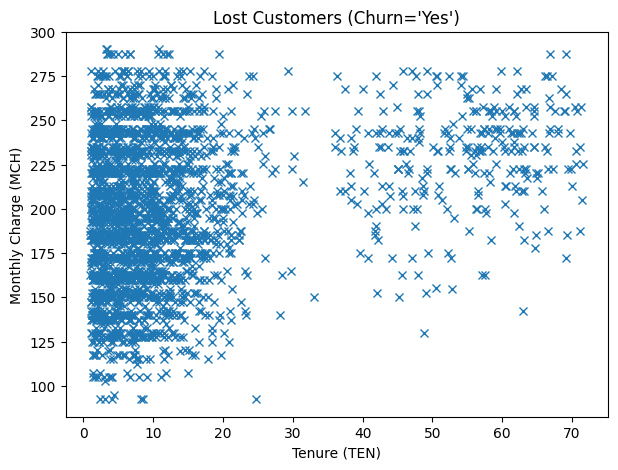

In [42]:
# create scatter plot of lost customers
fig, ax = plt.subplots(figsize =(7, 5))
plt.plot(df_numerical["TEN"], df_numerical["MCH"], marker="x", linestyle="")
plt.xlabel("Tenure (TEN)")
plt.ylabel("Monthly Charge (MCH)")
plt.title("Lost Customers (Churn='Yes')")



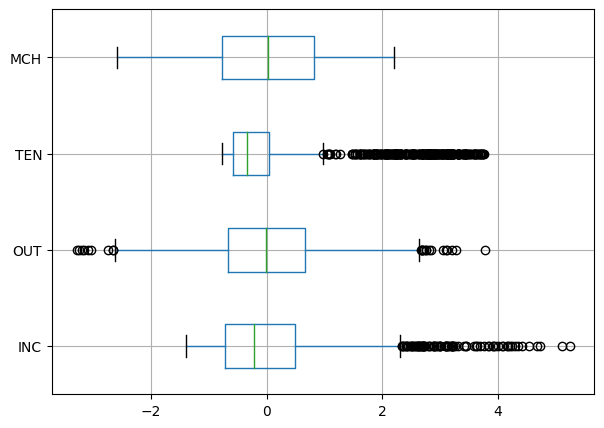

In [43]:
# use boxplot to look for outliers
fig, ax = plt.subplots(figsize =(7, 5))
ax = df_standardized.boxplot(vert=False)


Optimum: (3, 1251.564)


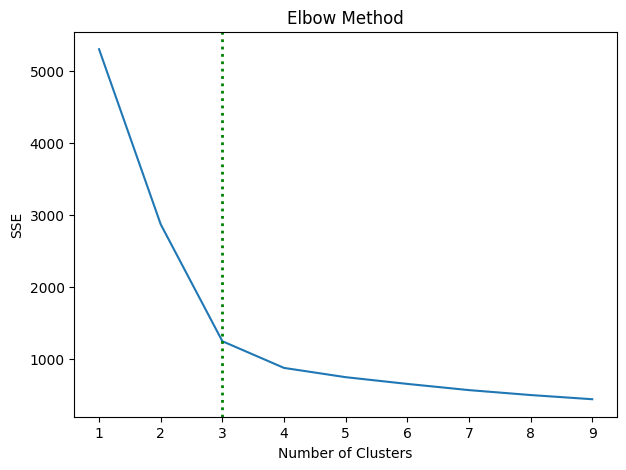

In [45]:
# find number of clusters using elbow, adapted code (Arvai, 2022)
M = df_standardized[['TEN','MCH']]
sse = [] # list of SSE values for each k
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(M)
    sse.append(kmeans.inertia_)
fig, ax = plt.subplots(figsize =(7, 5))
knee = KneeLocator(range(1, 10), sse, curve="convex", direction="decreasing")
plt.plot(range(1,10), sse)
plt.xticks(range(1,10))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.axvline(x=knee.elbow, color='green', ls=':', lw=2,)

# optimum point on knee plot
print('Optimum: ({}, {:.3f})'.format(knee.elbow, sse[knee.elbow-1]))


Max element :  0.6091972075742905
Returned tuple of arrays : (array([0], dtype=int64),)
List of Indices of maximum element : [0]


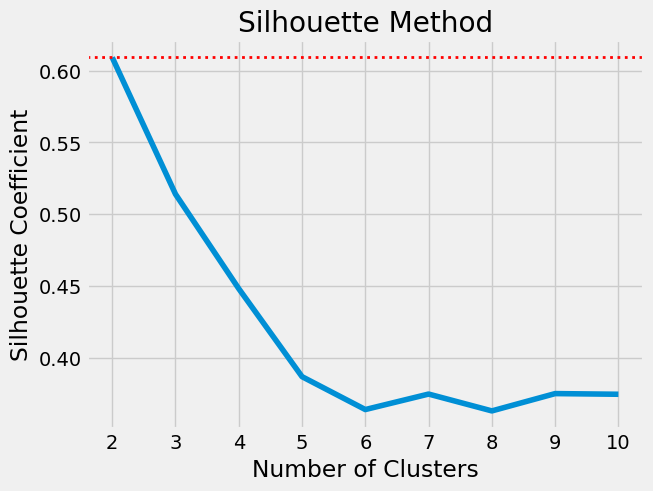

In [47]:
# find number of clusters using silhouette method, adapted code (Arvai, 2022)
from sklearn.metrics import silhouette_score
silhouette_coefficients = []
# Notice you start at 2 clusters for silhouette coefficient
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=10)
    kmeans.fit(M)
    score = silhouette_score(M, kmeans.labels_)
    silhouette_coefficients.append(score)
plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.title("Silhouette Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
ymax = np.amax(silhouette_coefficients)
print('Max element : ', ymax)
# Get the indices of maximum element in numpy array
result = np.where(silhouette_coefficients == np.amax(silhouette_coefficients))
print('Returned tuple of arrays :', result)
print('List of Indices of maximum element :', result[0])
plt.axhline(y=ymax, color='red', ls=':', lw=2,)


Text(0.5, 1.0, 'K-Means Clustering (k=2) for Lost Customers')

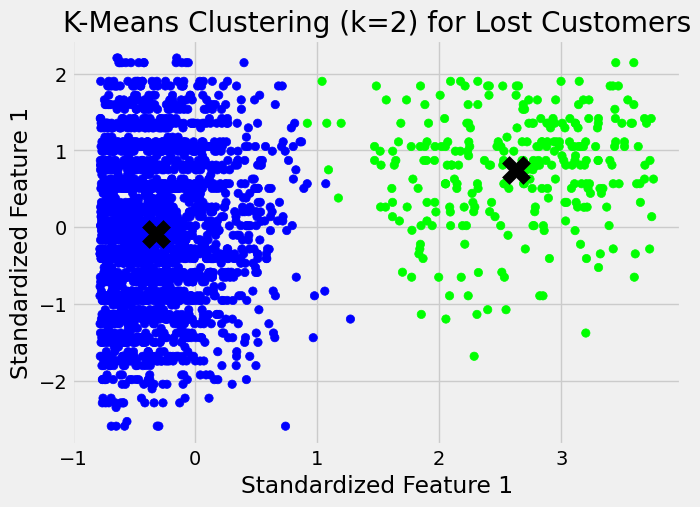

In [49]:
# final K-means analysis plot
n_clusters=2
kmeans = KMeans(n_clusters=n_clusters, random_state=10)
kmeans.fit(M)
fig, ax = plt.subplots(figsize =(7, 5))
title = 'K-Means Clustering (k=' + str(n_clusters) + ') for Lost Customers'
ax.scatter(x=M. iloc[:, 0],y=M. iloc[:, 1],
    c=kmeans.labels_,cmap='brg')
ax.scatter(x=kmeans.cluster_centers_[:,0],
    y=kmeans.cluster_centers_[:,1],
    color='black', marker='X',s=400 )
ax.set_xlabel('Standardized Feature 1')
ax.set_ylabel('Standardized Feature 1')
plt.title(title)


Text(0.5, 1.0, 'K-Means Clustering (k=3) for Lost Customers')

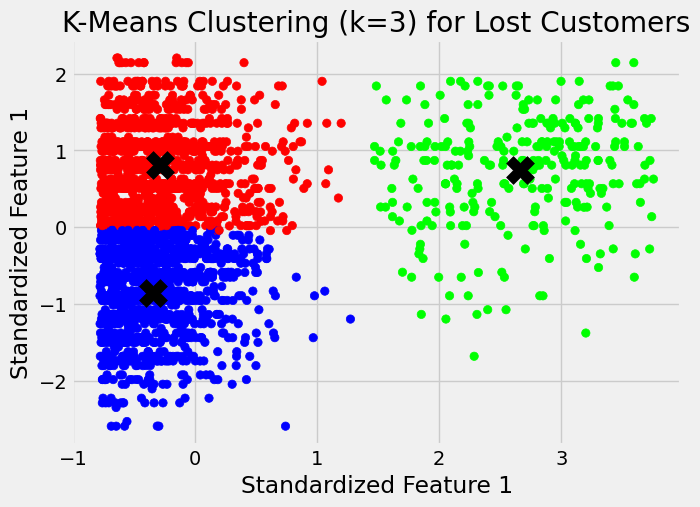

In [51]:
# final K-means analysis plot
n_clusters=3
kmeans = KMeans(n_clusters=n_clusters, random_state=10)
kmeans.fit(M)
fig, ax = plt.subplots(figsize =(7, 5))
title = 'K-Means Clustering (k=' + str(n_clusters) + ') for Lost Customers'
ax.scatter(x=M. iloc[:, 0],y=M. iloc[:, 1],
    c=kmeans.labels_,cmap='brg')
ax.scatter(x=kmeans.cluster_centers_[:,0],
    y=kmeans.cluster_centers_[:,1],
    color='black', marker='X',s=400 )
ax.set_xlabel('Standardized Feature 1')
ax.set_ylabel('Standardized Feature 1')
plt.title(title)

In [52]:
# adapted from code:
#https://towardsdatascience.com/silhouette-coefficient-validating-clustering-techniques-e976bb81d10c
from sklearn.metrics import silhouette_score
M = df_standardized[['TEN','MCH']]
for i in range(2,8):
    KMean= KMeans(n_clusters=i, random_state=10)
    KMean.fit(M)
    cluster_labels=KMean.predict(M)
    silhouette_avg = silhouette_score(M, cluster_labels)
    print('Silhouette score (n={}) is {:.8f}'.format(i,silhouette_avg  ))

Silhouette score (n=2) is 0.60919721
Silhouette score (n=3) is 0.51402229
Silhouette score (n=4) is 0.44820391
Silhouette score (n=5) is 0.38693915
Silhouette score (n=6) is 0.36404932
Silhouette score (n=7) is 0.37483239


For n_clusters = 2 The average silhouette_score is : 0.6091972075742905
For n_clusters = 3 The average silhouette_score is : 0.5140222937504278
For n_clusters = 4 The average silhouette_score is : 0.4482039104124485


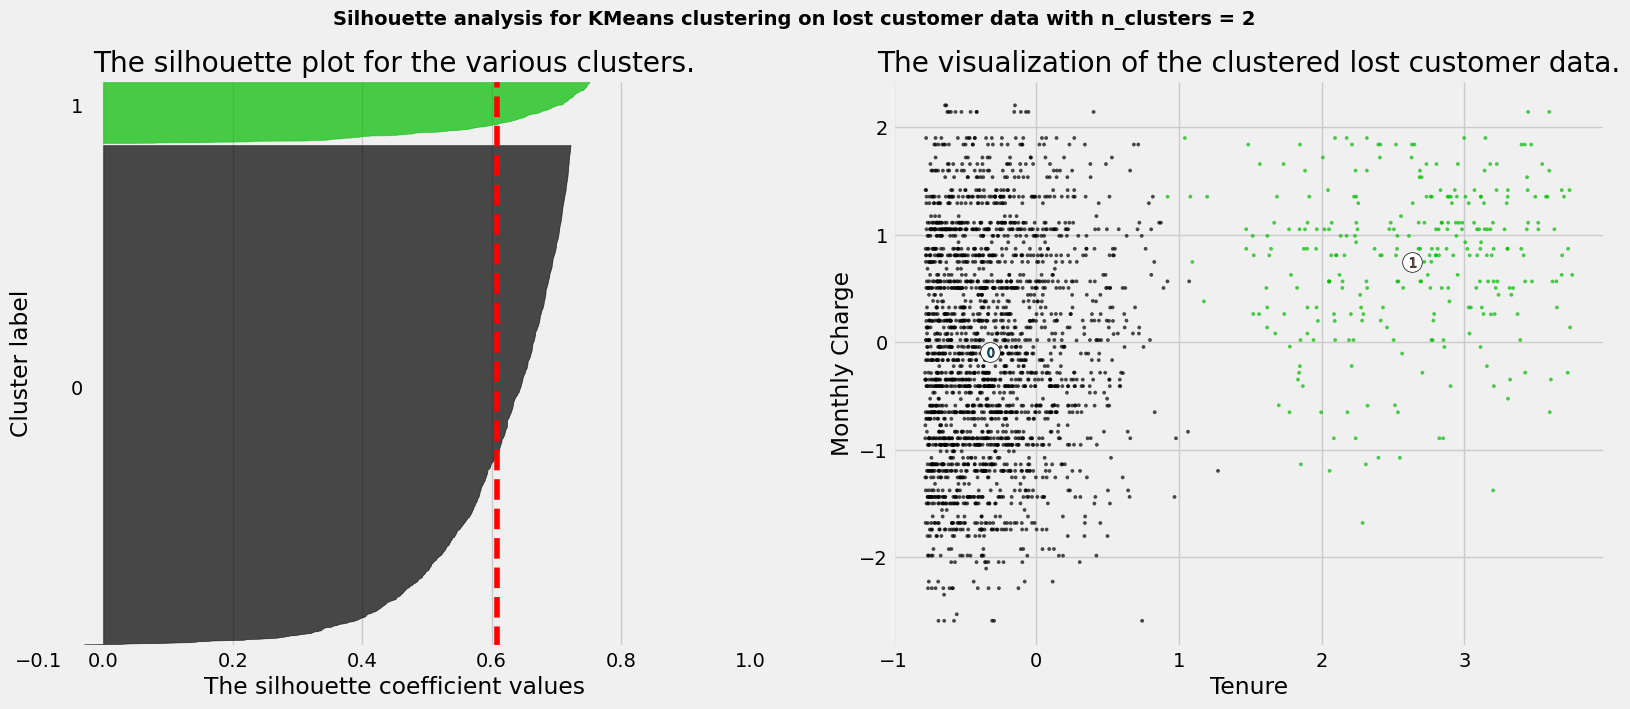

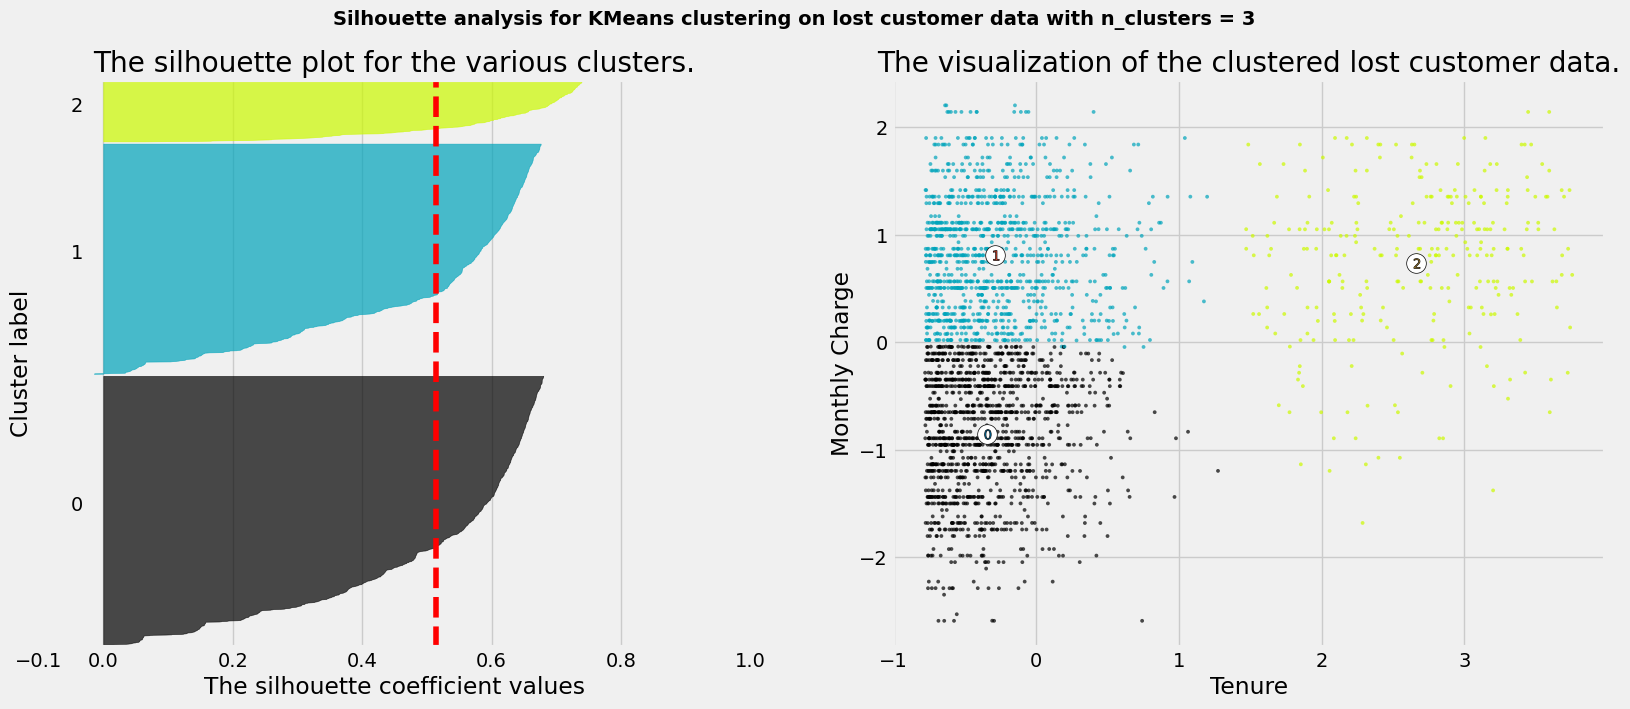

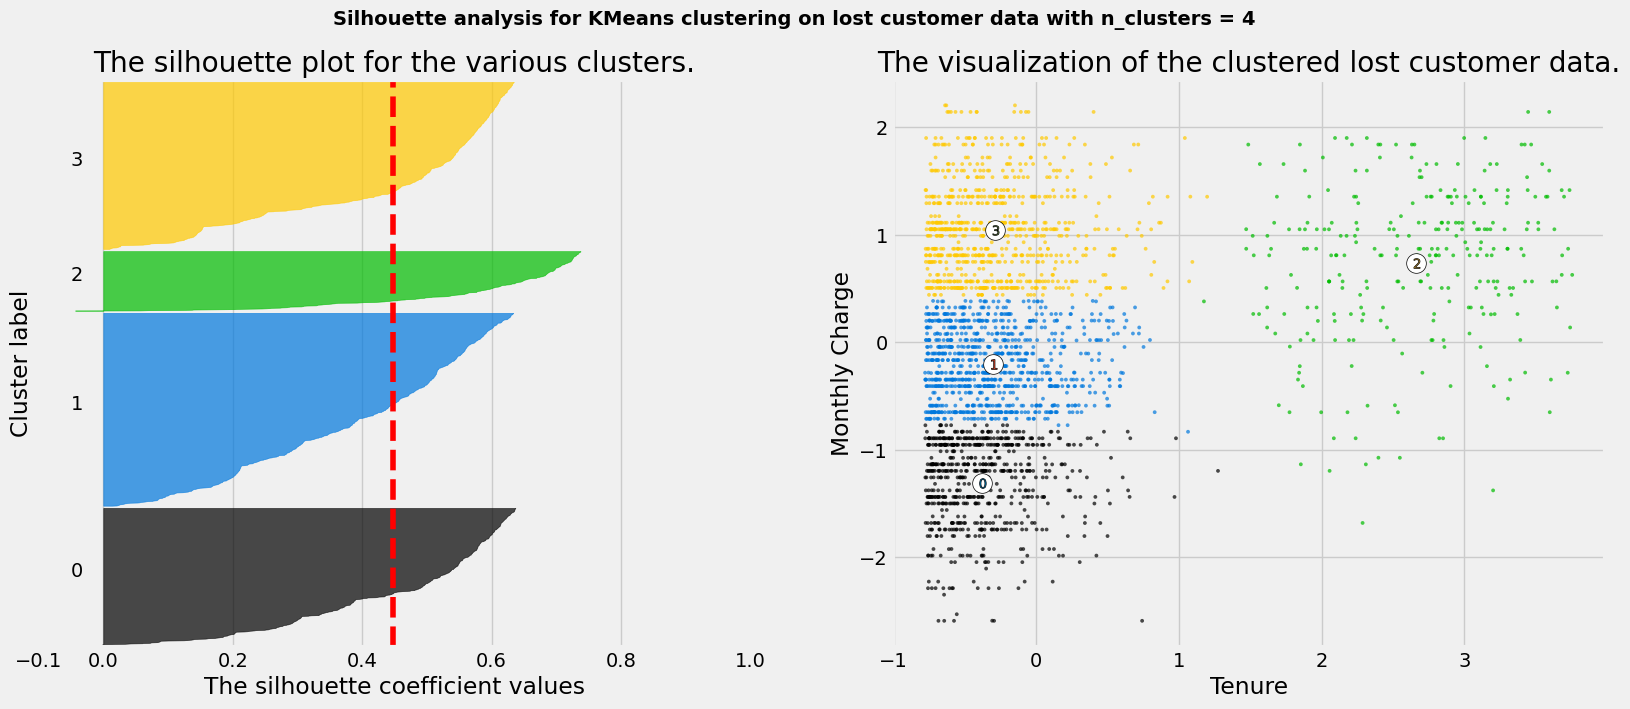

In [53]:

# adapted from code:
#https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
M = df_standardized[['TEN','MCH']]
X = M.to_numpy()
range_n_clusters = [2, 3, 4]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered lost customer data.")
    ax2.set_xlabel("Tenure")
    ax2.set_ylabel("Monthly Charge")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on lost customer data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()